In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
plt.rcParams["figure.figsize"] = (7, 5)


def plot(X, y, text=''):
    plt.scatter(x=X[:, 0], y=X[:, 1], c=y)  # y may be continous or discreet
    plt.title(text)

In [3]:
# XOR Dataset samples
def get_samples(n_samples):
    X = np.random.random((n_samples, 2))
    y = np.zeros((n_samples, 1))

    # assign labels according to XOR condition
    y[(X[:, 0] < 0.5) & (X[:, 1] > 0.5)] = 1
    y[(X[:, 0] > 0.5) & (X[:, 1] < 0.5)] = 1

    X[X > 0.5] += 0.08  # move the class blocks slightly further from each other
    X += np.random.random(
        (n_samples, 2)
    ) / 8  # add some noise at the edges of each class block

    return X, y

In [4]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


# Standard mlp forward function, with sigmoid activation
def forward(X, W):
    a = X
    for i in range(len(W)):
        w = W[i]
        assert w.shape[0] - 1 == a.shape[1]

        z = a @ w[:-1] + w[-1]
        a = sigmoid(z)

    y_hat = a
    return y_hat


def accuracy(y, y_hat):
    correct = np.sum(y == y_hat)
    acc = correct / len(y)
    return round(acc * 100, 2)


# reduce continous values into discreet classes
def discreetize(y_hat):
    y_hat[y_hat < 0.5] = 0
    y_hat[y_hat > 0.5] = 1

    return y_hat


# log of normal PDF.
# since probabilities will be multipled, log converts small +ve numbers into large -ve numbers.
def log_of_norm(z, mu, sd):
    return -np.log(sd * np.sqrt(2 * np.pi)) - ((z - mu)**2) / (2 * sd**2)

In [5]:
# defined such that weights are discouraged from having high magnitudes
def prior(W):
    W_prior = 0
    for i in range(len(W)):
        W_prior += np.sum(log_of_norm(W[i], 0, 1))

    return W_prior


# defined such that predictions lie close to the ground truths
# a low std dev imples a greater strictness
def likelihood(y, W, X):
    y_hat = forward(X, W)
    return np.sum(log_of_norm(y_hat, y, 0.0001))


def posterior(W, X, y):
    return likelihood(y, W, X) + prior(W)


In [6]:
# equivalent to each scaler s inside w being sampled from a normal distribution centered about s
def transition(w):
    return w + np.random.normal(0, 1, w.shape)


def shuffle(X, y):
    p = np.random.permutation(len(X))
    return X[p], y[p]


def accept(post, post_new):
    if post_new > post:
        return True
    else:
        prob = np.random.uniform(0, 1)
        return (
            prob < (np.exp(post_new - post))
        )  # exp, as posteriors are in log form


# metropolis hastings sampler
# burn_in_acc is the minimum accuracy that the markov chain must produce before samples are recorded
# patience is the maximum number of attempts the chain will make to grow by a single step. 
def MH(X, y, layers, burn_in_acc=75.0, patience=2500):
    # define weight matrices, given the network layers
    W = []
    for i in range(len(layers) - 1):
        W.append(np.zeros((layers[i] + 1, layers[i + 1])))

    attempts_since_step = 0 # count attempts made since the last chain growth step
    train_accs, val_accs = [], []
    weights = []

    while attempts_since_step < patience:
        X, y = shuffle(X, y)

        # attempt to sample
        W_new = [transition(w) for w in W]

        post = posterior(W, X, y)
        post_new = posterior(W_new, X, y)

        # retry if sample cannot be accepted
        if not accept(post, post_new):
            attempts_since_step += 1
            continue

        # sample accepted! the chain grows.
        attempts_since_step = 0
        W = W_new

        # record test accuracy
        train_pred = discreetize(forward(X, W_new))
        train_acc = accuracy(y, train_pred)
        train_accs.append(train_acc)
        
        # record validation accuracy
        X_val, y_val = get_samples(1000)
        val_pred = discreetize(forward(X_val, W_new))
        val_acc = accuracy(y_val, val_pred)
        val_accs.append(val_acc)

        # drop burn-in of markov chain
        if train_acc > burn_in_acc:
            weights.append(W_new)

    return weights, train_accs, val_accs


# random sampler
def random_sampler(X, y, layers, n_samples=20):
    # define weight matrices, given the network layers
    W = []
    for i in range(len(layers) - 1):
        W.append(np.zeros((layers[i] + 1, layers[i + 1])))

    weights = []

    for _ in range(n_samples):
        X, y = shuffle(X, y)
        W = [transition(w) for w in W]
        
        # accept sample
        weights.append(W)
    
    return weights
    

No. of sampled weights: 20


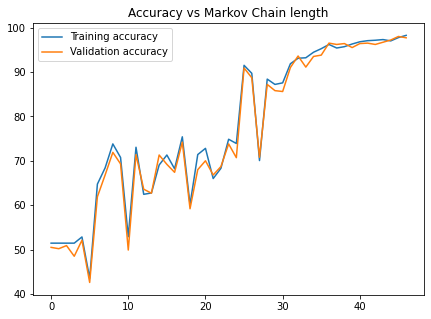

In [18]:
X_train, y_train = get_samples(2000)

# MH MCMC sampling
weights, train_accs, val_accs = MH(X_train, y_train, [2, 3, 3, 1], burn_in_acc=87.5, patience=8000)
n_MH_samples = len(weights) # number of samples the MH MCMC chain was able to collect
print(f'No. of sampled weights: {n_MH_samples}')

# plot training and valication accuracy
plt.plot(train_accs, label='Training accuracy')
plt.plot(val_accs, label='Validation accuracy')
plt.title('Accuracy vs Markov Chain length')
plt.legend()
plt.show()

# random sampling
weights_rand = random_sampler(X_train, y_train, [2, 3, 3, 1], n_samples=n_MH_samples)

In [8]:
def ensemble_predict(X, y, weights):
    preds, accs = [], []
    
    # store predictions and accuracy produced by each sampled weight
    for W in weights:
        y_hat = forward(X, W)
        preds.append(y_hat)
        accs.append(accuracy(y, discreetize(y_hat)))

    # find mean (ensembling) and stdev of predictions along the sample axis 
    preds = np.array(preds)
    pred_means = np.mean(preds, axis=0)
    pred_stdevs = np.std(preds, axis=0)
    
    plot(X, pred_means, f'Mean predictions using all sampled weights')
    
    # find stdev in the predction means
    mean_pred_stdev = np.mean(pred_stdevs)
    print(f'Average standard deviation accross all data points:', round(mean_pred_stdev, 4))
    
    # find mean and stdev of accuracy along sample axis
    accs = np.array(accs)
    mean_acc = np.mean(accs)
    acc_stdev = np.std(accs)
    print(f'Average accuracy: {round(mean_acc, 2)} %')
    print(f'Accuracy stdev: {round(acc_stdev, 4)} %')


Results using Metropolis Hastings sampler:
Average standard deviation accross all data points: 0.1069
Average accuracy: 92.85 %
Accuracy stdev: 3.4613 %


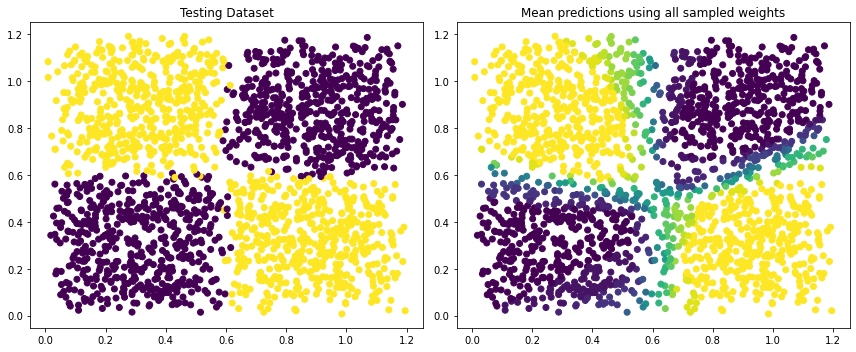

Results using Random sampler:
Average standard deviation accross all data points: 0.238
Average accuracy: 53.15 %
Accuracy stdev: 4.1008 %


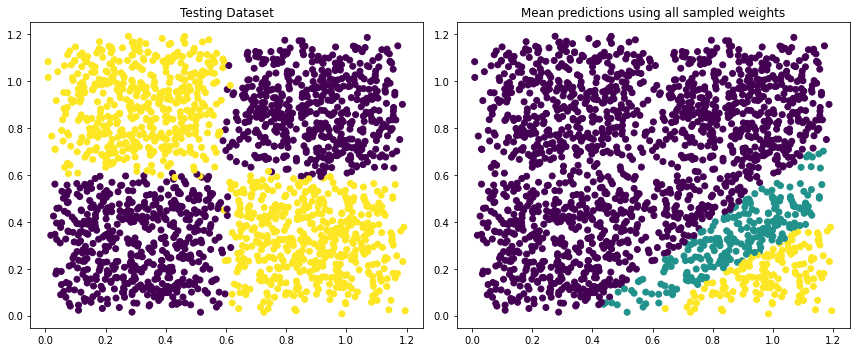

In [28]:
plt.rcParams["figure.figsize"] = (12,5)
X_test, y_test = get_samples(2000)

print('Results using Metropolis Hastings sampler:')
gs = gridspec.GridSpec(1, 2)    
ax = plt.subplot(gs[0, 0])
plot(X_test, y_test, 'Testing Dataset')
ax = plt.subplot(gs[0, 1]) 
ensemble_predict(X_test, y_test, weights)
plt.tight_layout()
plt.show()

print('Results using Random sampler:')
gs = gridspec.GridSpec(1, 2)    
ax = plt.subplot(gs[0, 0])
plot(X_test, y_test, 'Testing Dataset')
ax = plt.subplot(gs[0, 1]) 
ensemble_predict(X_test, y_test, weights_rand)
plt.tight_layout()
plt.show()